In [1]:
import numpy as np
import pandas as pd

In [2]:
# Selecting 6 lables randomly form 20 newsgroups dataset
import random
lab = random.sample(range(0, 19), 6)
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball',
              'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space',
              'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc',
              'talk.religion.misc', 'alt.atheism']

In [3]:
lab.sort()
cats = [categories[i] for i in lab]
cats

['comp.sys.ibm.pc.hardware',
 'sci.electronics',
 'sci.space',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.religion.misc']

In [4]:
from sklearn.datasets import fetch_20newsgroups
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
newsgroups = fetch_20newsgroups(categories=cats, remove=('headers', 'footers', 'quotes'))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /usr/share/nltk_data...
[nltk_data]    | Downloading pa

True

In [6]:
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokenized = word_tokenize(text)
    porter = PorterStemmer()
    text = ' '.join([porter.stem(word) for word in tokenized])
    return text

docs = [preprocess(text) for text in newsgroups.data]

In [7]:
tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(docs)]
model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4, epochs=20)
document_vectors = [model.infer_vector(text.split()) for text in docs]

In [8]:
set(newsgroups.target.tolist())

{0, 1, 2, 3, 4, 5}

In [9]:
doc_names = ['Doc {}'.format(i) for i in range(len(docs))]
lables = [cats[lab] for lab in list(newsgroups.target)]
df = pd.DataFrame()
df['Docs'] = doc_names
df['vec'] = document_vectors
df['lables'] = lables
df['numLables'] = newsgroups.target

In [10]:
df

,Docs,vec,lables,numLables
0,Doc 0,"[-1.0140965, 0.26422897, -0.7370822, 0.5491448...",sci.electronics,1
1,Doc 1,"[-0.47756976, -0.115322635, -0.06258819, -0.92...",sci.space,2
2,Doc 2,"[0.17446418, -0.05805279, -0.025195248, -0.173...",sci.electronics,1
3,Doc 3,"[0.007223278, -0.11381164, -0.05451708, 0.0309...",talk.politics.mideast,4
4,Doc 4,"[-0.70942324, -0.56741303, -0.25280392, -0.262...",sci.space,2
...,...,...,...,...
3256,Doc 3256,"[-0.15798788, 0.42025125, 0.11233851, -0.55544...",talk.politics.mideast,4
3257,Doc 3257,"[-1.4022155, 0.45490274, -0.9800541, -1.181388...",sci.space,2
3258,Doc 3258,"[-0.09646834, -0.045914527, -0.048647918, -0.0...",talk.religion.misc,5
3259,Doc 3259,"[-0.24464202, 0.00012730865, -0.099553086, -0....",talk.politics.mideast,4


In [11]:
df['lables'].value_counts()

sci.space                   593
sci.electronics             591
comp.sys.ibm.pc.hardware    590
talk.politics.mideast       564
talk.politics.guns          546
talk.religion.misc          377
Name: lables, dtype: int64

# computing dissmilarity

In [12]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
def getDissimMatrix(df) : 
  n = df.shape[0]
  res = np.zeros((n, n))
  for i in range(n) :
    for j in range(i + 1, n) : 
      res[i, j] = res[j, i] = 1 - getCosSim(df.iloc[i]['vec'], df.iloc[j]['vec'])
    if i % 100 == 0 : print('Node', i, 'completed')
  return res

In [14]:
def getCosSim(vec1, vec2) : 
  return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

In [15]:
disMat = getDissimMatrix(df)
disMat_df = pd.DataFrame(disMat, columns = df.index, index = df.index)
disMat_df

Node 0 completed
Node 100 completed
Node 200 completed
Node 300 completed
Node 400 completed
Node 500 completed
Node 600 completed
Node 700 completed
Node 800 completed
Node 900 completed
Node 1000 completed
Node 1100 completed
Node 1200 completed
Node 1300 completed
Node 1400 completed
Node 1500 completed
Node 1600 completed
Node 1700 completed
Node 1800 completed
Node 1900 completed
Node 2000 completed
Node 2100 completed
Node 2200 completed
Node 2300 completed
Node 2400 completed
Node 2500 completed
Node 2600 completed
Node 2700 completed
Node 2800 completed
Node 2900 completed
Node 3000 completed
Node 3100 completed
Node 3200 completed


,0,1,2,3,4,5,6,7,8,9,...,3251,3252,3253,3254,3255,3256,3257,3258,3259,3260
0,0.000000,0.755434,0.571310,0.618401,0.593786,0.595053,0.736872,1.021226,0.559253,0.552194,...,0.544377,0.716858,0.731672,0.486092,0.820601,0.714979,0.741776,0.461531,0.766979,0.681498
1,0.755434,0.000000,0.556376,0.712109,0.695897,0.581559,0.846023,0.865256,0.745232,0.645003,...,0.914040,0.844486,0.874026,0.632920,0.781032,0.758259,0.661847,0.578631,0.664505,0.830735
2,0.571310,0.556376,0.000000,0.469515,0.660642,0.338782,0.653341,0.846110,0.448720,0.574712,...,0.740088,0.603254,0.734840,0.515550,0.652809,0.605146,0.589297,0.387551,0.500170,0.787759
3,0.618401,0.712109,0.469515,0.000000,0.481363,0.418884,0.577930,0.661709,0.647542,0.608218,...,0.732387,0.442644,0.752013,0.595114,0.664874,0.665998,0.827293,0.559550,0.631624,0.539090
4,0.593786,0.695897,0.660642,0.481363,0.000000,0.611757,0.858416,0.781217,0.754549,0.693636,...,0.686972,0.638553,0.828308,0.708484,0.873851,0.858108,0.844285,0.486065,0.716598,0.780985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3256,0.714979,0.758259,0.605146,0.665998,0.858108,0.644135,0.665812,0.902648,0.792813,0.808887,...,0.574484,0.686378,0.682828,0.806221,0.740106,0.000000,0.709068,0.650108,0.684164,0.781086
3257,0.741776,0.661847,0.589297,0.827293,0.844285,0.538124,0.808204,0.889230,0.767832,0.801087,...,0.861537,0.720081,0.792860,0.587686,0.945625,0.709068,0.000000,0.557764,0.451191,0.972338
3258,0.461531,0.578631,0.387551,0.559550,0.486065,0.331199,0.572024,0.843147,0.444635,0.534581,...,0.539186,0.621000,0.721462,0.613069,0.643252,0.650108,0.557764,0.000000,0.415745,0.729231
3259,0.766979,0.664505,0.500170,0.631624,0.716598,0.377002,0.739056,0.938117,0.585315,0.687082,...,0.784173,0.673412,0.571581,0.693921,0.854355,0.684164,0.451191,0.415745,0.000000,0.814385


# Clustering

In [16]:
from sklearn import preprocessing as pp

In [17]:
class BinaryQP(object) : 
    def __init__(self, adjacency) : 
        
        self.adj = adjacency
        self.n = len(self.adj)
        
        self.pot = np.array([0 for i in range(self.n)])
        self.constant = 0
        n = self.n
        
        cost_matrix = np.zeros((n+1, n+1))
        cost_matrix[np.ix_(list(range(n)),list(range(n)))] = self.adj
        cost_matrix[np.ix_([n],list(range(n)))] = [i/2 for i in self.pot]
        cost_matrix[np.ix_(list(range(n))),[n]] = [i/2 for i in self.pot]
        cost_matrix[n][n] = self.constant
        
        self.cost_matrix = cost_matrix
        
    def __str__(self) : 
        print("The Cost Matrix (S) is :")
        return str(self.cost_matrix)

In [18]:
df['n'] = df['numLables']

In [19]:
df

,Docs,vec,lables,numLables,n
0,Doc 0,"[-1.0140965, 0.26422897, -0.7370822, 0.5491448...",sci.electronics,1,1
1,Doc 1,"[-0.47756976, -0.115322635, -0.06258819, -0.92...",sci.space,2,2
2,Doc 2,"[0.17446418, -0.05805279, -0.025195248, -0.173...",sci.electronics,1,1
3,Doc 3,"[0.007223278, -0.11381164, -0.05451708, 0.0309...",talk.politics.mideast,4,4
4,Doc 4,"[-0.70942324, -0.56741303, -0.25280392, -0.262...",sci.space,2,2
...,...,...,...,...,...
3256,Doc 3256,"[-0.15798788, 0.42025125, 0.11233851, -0.55544...",talk.politics.mideast,4,4
3257,Doc 3257,"[-1.4022155, 0.45490274, -0.9800541, -1.181388...",sci.space,2,2
3258,Doc 3258,"[-0.09646834, -0.045914527, -0.048647918, -0.0...",talk.religion.misc,5,5
3259,Doc 3259,"[-0.24464202, 0.00012730865, -0.099553086, -0....",talk.politics.mideast,4,4


In [20]:
def solveUsingEPSDP(problem, Grad, rank,la, ga, steps):
    C = problem.cost_matrix
    D = np.diag(np.sum(C, axis=0))
    L = D - C
    C = L
    V = np.random.normal(0, 1, (rank, len(C)))
    V = np.transpose(pp.normalize(np.transpose(V), norm='l2'))
    step = 1/np.linalg.norm(C) 
    
    for outer_steps in range(10): 
        gradient = 2*np.matmul(V, C) - la*Grad(V)
        for s in range(steps):
            gradient = 2*np.matmul(V, C) - la*Grad(V)
            V = V + step*(gradient)
            V = np.transpose(pp.normalize(np.transpose(V), norm='l2'))
        la = la*ga
    U, s, Vt = np.linalg.svd(V)
    v1 = Vt.T[:, 0]
    return v1

def RenyiGrad(V):
    alpha = 4
    U1, d, U2 = np.linalg.svd(V, full_matrices=False)
    D = np.diag(d)
    R=U2.shape[1]
    I=np.identity(R, dtype="int")
    xa=(np.dot(U1, np.dot(np.linalg.matrix_power(D, 2*alpha-1),U2)))
    trxa=np.trace(np.linalg.matrix_power(D, 2*alpha))
    trx=np.trace(np.dot(D, D))
    x=np.dot(np.transpose(V),V)
    h=xa/trxa
    p=x/trx
    k = h @ (I-p) 
    return (alpha/(1-alpha))*k


def TsallisGrad(V):
    alpha = 4
    U1, d, U2 = np.linalg.svd(V, full_matrices=False)
    D = np.diag(d)    
    return (alpha/(1-alpha))*(np.dot(U1, np.dot(np.linalg.matrix_power(D, 2*alpha-1),U2))/np.power(np.trace(np.dot(D, D)), alpha) -  np.trace(np.linalg.matrix_power(D, 2*alpha))*V/np.power(np.trace(np.dot(D, D)), alpha+1) )


In [21]:
n = disMat.shape[0]
def getAdj(nodes, disMat_df) : 
  n = len(nodes)
  return disMat_df.iloc[nodes, nodes].to_numpy()

In [22]:
def getLables(problem : BinaryQP, Grad = TsallisGrad) : 
  res = solveUsingEPSDP(problem, Grad, rank = 20, la = 10, ga = 5, steps = 100 )
  n = problem.n
  r = np.random.randn(n + 1)
  lables = list(np.sign(res))
  return lables

In [23]:
class ClusterNode(object) :
  def __init__(self, items : list, level : int, config : list) : 
    self.items = items
    self.level = level
    self.config = config
    self.left = None
    self.right = None
  
  def __str__(self) : 
    res = 'items : ' + str(self.items) + '\n'
    res += 'level : ' + str(self.level) + '\n'
    res += 'config : ' + str(self.config) + '\n'
    return res

In [24]:
max_clusters = 10

In [25]:
def getWCSS(node : ClusterNode) : 
  items = node.items
  centroid = np.zeros(df.loc[0, 'vec'].shape[0])
  for item in items : 
    centroid += df.loc[item, 'vec']
  centroid = centroid / len(items)
  res = 0 
  for item in items : 
    res += np.linalg.norm(centroid - df.loc[item, 'vec'])
  return res 

# Using Tsalis Entropy

In [26]:
from heapq import heappush, heappop
treeMemo = dict()
wcssMemo = dict()

In [27]:

def divisiveCluster(disMat_df, leafLength) -> ClusterNode : 
  n = disMat_df.shape[0]
  root = ClusterNode (
      items = list(range(n)),
      level = 0,
      config = []
  )

  q = [(0, root)]

  while len(q) < max_clusters : 
    treeMemo[len(q)] = q.copy()
    # total_WCSS = sum([-(i* len(j.items)) for i, j in q])
    total_WCSS = sum([-i for i, j in q])
    wcssMemo[len(q)] = total_WCSS / len(q)
    _, currNode = q.pop(0)
    if len(currNode.items) < leafLength : continue
    # print('Cluster at level : ', currNode.level, 'is divided into ', end = " ")
    adj = getAdj(currNode.items, disMat_df)
    problem = BinaryQP(adj)
    lables = getLables(problem, TsallisGrad)
    pos =  []
    neg = []
    for item, lable in zip(currNode.items, lables) : 
      if lable > 0 : pos.append(item)
      else : neg.append(item)

    leftCluster = ClusterNode(items = neg, level = currNode.level + 1, config = currNode.config + [-1])
    rightCluster = ClusterNode(items = pos, level = currNode.level+ 1, config = currNode.config + [1] )
    currNode.left = leftCluster
    currNode.right = rightCluster 
    heappush(q, (-getWCSS(leftCluster), leftCluster))
    heappush(q, (-getWCSS(rightCluster), rightCluster))

    print('Cluster at level '+ str(currNode.level) +  ' with ' +  str(len(currNode.items)) + ' divided into ' + str( len(currNode.left.items))  +' and ' + str(len(currNode.right.items)) + ' nodes.'   )
    print(currNode)



  return root

In [28]:
rootCluster = divisiveCluster(disMat_df,20)

Cluster at level 0 with 3261 divided into 1637 and 1624 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207

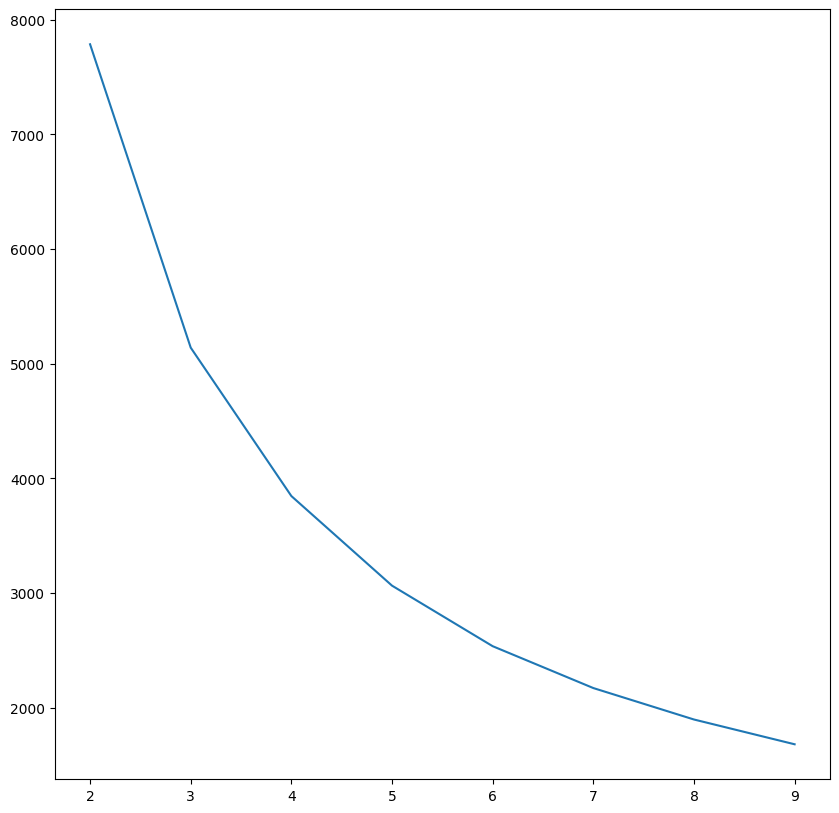

In [29]:
import matplotlib.pyplot as plt
del wcssMemo[1]
plt.figure(figsize=(10, 10))
plt.plot(wcssMemo.keys(), wcssMemo.values())
plt.show()

In [30]:
clusters = treeMemo[6]

In [31]:
memo = dict()
for id, _ in enumerate(clusters) : 
  _, cluster = _
  for item in cluster.items : 
    memo[item] = id


vals = sorted(memo.items())
vals = [i for j, i in vals]

df['pred'] = vals
df

,Docs,vec,lables,numLables,n,pred
0,Doc 0,"[-1.0140965, 0.26422897, -0.7370822, 0.5491448...",sci.electronics,1,1,1
1,Doc 1,"[-0.47756976, -0.115322635, -0.06258819, -0.92...",sci.space,2,2,1
2,Doc 2,"[0.17446418, -0.05805279, -0.025195248, -0.173...",sci.electronics,1,1,1
3,Doc 3,"[0.007223278, -0.11381164, -0.05451708, 0.0309...",talk.politics.mideast,4,4,1
4,Doc 4,"[-0.70942324, -0.56741303, -0.25280392, -0.262...",sci.space,2,2,0
...,...,...,...,...,...,...
3256,Doc 3256,"[-0.15798788, 0.42025125, 0.11233851, -0.55544...",talk.politics.mideast,4,4,0
3257,Doc 3257,"[-1.4022155, 0.45490274, -0.9800541, -1.181388...",sci.space,2,2,0
3258,Doc 3258,"[-0.09646834, -0.045914527, -0.048647918, -0.0...",talk.religion.misc,5,5,1
3259,Doc 3259,"[-0.24464202, 0.00012730865, -0.099553086, -0....",talk.politics.mideast,4,4,1


In [32]:
df['pred'].value_counts()

1    887
0    754
5    444
4    426
3    392
2    358
Name: pred, dtype: int64

In [33]:
df2 = df.copy()

In [34]:
df2

,Docs,vec,lables,numLables,n,pred
0,Doc 0,"[-1.0140965, 0.26422897, -0.7370822, 0.5491448...",sci.electronics,1,1,1
1,Doc 1,"[-0.47756976, -0.115322635, -0.06258819, -0.92...",sci.space,2,2,1
2,Doc 2,"[0.17446418, -0.05805279, -0.025195248, -0.173...",sci.electronics,1,1,1
3,Doc 3,"[0.007223278, -0.11381164, -0.05451708, 0.0309...",talk.politics.mideast,4,4,1
4,Doc 4,"[-0.70942324, -0.56741303, -0.25280392, -0.262...",sci.space,2,2,0
...,...,...,...,...,...,...
3256,Doc 3256,"[-0.15798788, 0.42025125, 0.11233851, -0.55544...",talk.politics.mideast,4,4,0
3257,Doc 3257,"[-1.4022155, 0.45490274, -0.9800541, -1.181388...",sci.space,2,2,0
3258,Doc 3258,"[-0.09646834, -0.045914527, -0.048647918, -0.0...",talk.religion.misc,5,5,1
3259,Doc 3259,"[-0.24464202, 0.00012730865, -0.099553086, -0....",talk.politics.mideast,4,4,1


In [35]:
from collections import defaultdict
jacScores = pd.DataFrame(np.zeros(36).reshape(6, 6))
jacScores

,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
true_labels = df['numLables'].tolist()
predicted_labels = df['pred'].tolist()

truths = defaultdict(lambda : set())
preds = defaultdict(lambda : set())

for ind, label in enumerate(true_labels) :
    truths[label].add(ind)

for ind, label in enumerate(predicted_labels) : 
    preds[label].add(ind)

In [37]:
for t in range(6) : 
    for p in range(6) : 
        jacScores.iloc[t,p] = len(truths[t].intersection(preds[p])) 
jacScores

,0,1,2,3,4,5
0,55.0,113.0,1.0,7.0,297.0,117.0
1,148.0,127.0,4.0,16.0,121.0,175.0
2,227.0,225.0,16.0,58.0,5.0,62.0
3,125.0,171.0,51.0,153.0,2.0,44.0
4,96.0,129.0,270.0,46.0,0.0,23.0
5,103.0,122.0,16.0,112.0,1.0,23.0


In [38]:
from heapq import heapify, heappush, heappop
heap = [] #(val, ground, pred)
for t in range(6) : 
    for p in range(6) : 
        heappush(heap, (-jacScores.iloc[t, p], t, p ))
groundSeen = set()
predSeen = set()
mappedLabels = dict()
while len(groundSeen) != 6 :
    _, t, p = heappop(heap)
    if t in groundSeen or p in predSeen : continue
    mappedLabels[p] = t
    groundSeen.add(t)
    predSeen.add(p)
mappedLabels

{4: 0, 2: 4, 0: 2, 5: 1, 1: 3, 3: 5}

In [39]:
df['mapped'] = df['pred'].map(lambda x : mappedLabels[x])
df

,Docs,vec,lables,numLables,n,pred,mapped
0,Doc 0,"[-1.0140965, 0.26422897, -0.7370822, 0.5491448...",sci.electronics,1,1,1,3
1,Doc 1,"[-0.47756976, -0.115322635, -0.06258819, -0.92...",sci.space,2,2,1,3
2,Doc 2,"[0.17446418, -0.05805279, -0.025195248, -0.173...",sci.electronics,1,1,1,3
3,Doc 3,"[0.007223278, -0.11381164, -0.05451708, 0.0309...",talk.politics.mideast,4,4,1,3
4,Doc 4,"[-0.70942324, -0.56741303, -0.25280392, -0.262...",sci.space,2,2,0,2
...,...,...,...,...,...,...,...
3256,Doc 3256,"[-0.15798788, 0.42025125, 0.11233851, -0.55544...",talk.politics.mideast,4,4,0,2
3257,Doc 3257,"[-1.4022155, 0.45490274, -0.9800541, -1.181388...",sci.space,2,2,0,2
3258,Doc 3258,"[-0.09646834, -0.045914527, -0.048647918, -0.0...",talk.religion.misc,5,5,1,3
3259,Doc 3259,"[-0.24464202, 0.00012730865, -0.099553086, -0....",talk.politics.mideast,4,4,1,3


In [40]:
from sklearn.metrics.cluster import rand_score
print('Rand Index : ', rand_score(df['numLables'].values,df['mapped'].values))

from sklearn.metrics import classification_report
print(classification_report(df['numLables'].values, df['mapped'].values))

Rand Index :  0.7389579018066271
              precision    recall  f1-score   support

           0       0.70      0.50      0.58       590
           1       0.39      0.30      0.34       591
           2       0.30      0.38      0.34       593
           3       0.19      0.31      0.24       546
           4       0.75      0.48      0.59       564
           5       0.29      0.30      0.29       377

    accuracy                           0.38      3261
   macro avg       0.44      0.38      0.40      3261
weighted avg       0.45      0.38      0.40      3261



# Using Renyis Entropy

In [41]:
from heapq import heappush, heappop
treeMemo = dict()
wcssMemo = dict()



def divisiveCluster(disMat_df, leafLength) -> ClusterNode : 
  n = disMat_df.shape[0]
  root = ClusterNode (
      items = list(range(n)),
      level = 0,
      config = []
  )

  q = [(0, root)]

  while len(q) < max_clusters : 
    treeMemo[len(q)] = q.copy()
    # total_WCSS = sum([-(i* len(j.items)) for i, j in q])
    total_WCSS = sum([-i for i, j in q])
    wcssMemo[len(q)] = total_WCSS / len(q)
    _, currNode = q.pop(0)
    if len(currNode.items) < leafLength : continue
    # print('Cluster at level : ', currNode.level, 'is divided into ', end = " ")
    adj = getAdj(currNode.items, disMat_df)
    problem = BinaryQP(adj)
    lables = getLables(problem, RenyiGrad)
    pos =  []
    neg = []
    for item, lable in zip(currNode.items, lables) : 
      if lable > 0 : pos.append(item)
      else : neg.append(item)

    leftCluster = ClusterNode(items = neg, level = currNode.level + 1, config = currNode.config + [-1])
    rightCluster = ClusterNode(items = pos, level = currNode.level+ 1, config = currNode.config + [1] )
    currNode.left = leftCluster
    currNode.right = rightCluster 
    heappush(q, (-getWCSS(leftCluster), leftCluster))
    heappush(q, (-getWCSS(rightCluster), rightCluster))

    print('Cluster at level '+ str(currNode.level) +  ' with ' +  str(len(currNode.items)) + ' divided into ' + str( len(currNode.left.items))  +' and ' + str(len(currNode.right.items)) + ' nodes.'   )
    print(currNode)



  return root

In [42]:
rootCluster = divisiveCluster(disMat_df,20)

Cluster at level 0 with 3261 divided into 1655 and 1606 nodes.
items : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207

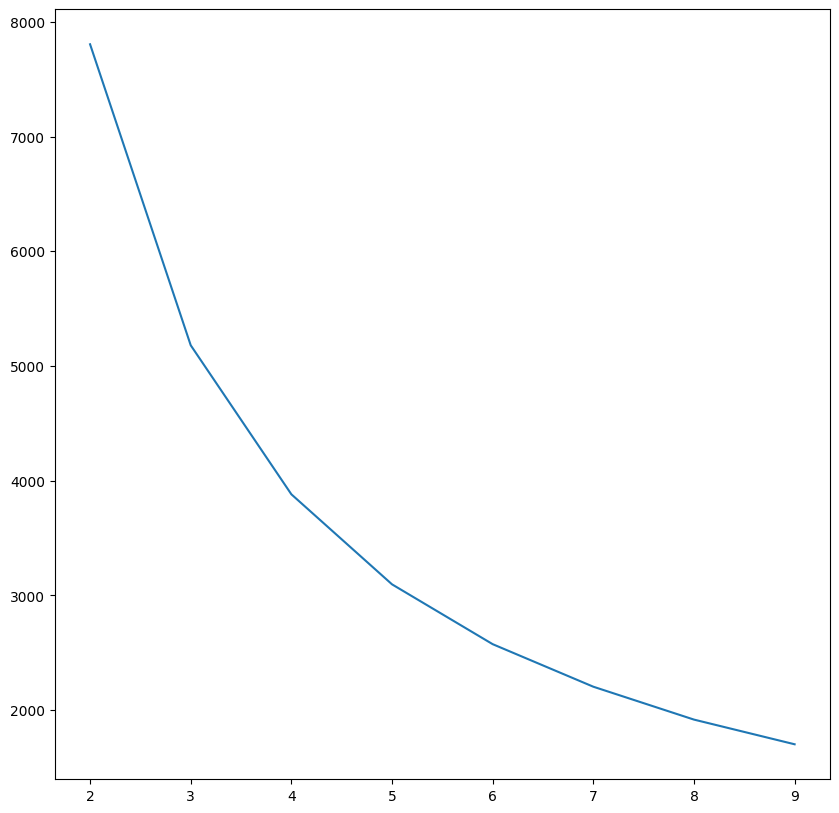

In [43]:
import matplotlib.pyplot as plt
del wcssMemo[1]
plt.figure(figsize=(10, 10))
plt.plot(wcssMemo.keys(), wcssMemo.values())
plt.show()

In [44]:
clusters = treeMemo[6]

In [45]:
memo = dict()
for id, _ in enumerate(clusters) : 
  _, cluster = _
  for item in cluster.items : 
    memo[item] = id


vals = sorted(memo.items())
vals = [i for j, i in vals]

df['pred'] = vals
df

,Docs,vec,lables,numLables,n,pred,mapped
0,Doc 0,"[-1.0140965, 0.26422897, -0.7370822, 0.5491448...",sci.electronics,1,1,0,3
1,Doc 1,"[-0.47756976, -0.115322635, -0.06258819, -0.92...",sci.space,2,2,2,3
2,Doc 2,"[0.17446418, -0.05805279, -0.025195248, -0.173...",sci.electronics,1,1,1,3
3,Doc 3,"[0.007223278, -0.11381164, -0.05451708, 0.0309...",talk.politics.mideast,4,4,0,3
4,Doc 4,"[-0.70942324, -0.56741303, -0.25280392, -0.262...",sci.space,2,2,1,2
...,...,...,...,...,...,...,...
3256,Doc 3256,"[-0.15798788, 0.42025125, 0.11233851, -0.55544...",talk.politics.mideast,4,4,0,2
3257,Doc 3257,"[-1.4022155, 0.45490274, -0.9800541, -1.181388...",sci.space,2,2,0,2
3258,Doc 3258,"[-0.09646834, -0.045914527, -0.048647918, -0.0...",talk.religion.misc,5,5,1,3
3259,Doc 3259,"[-0.24464202, 0.00012730865, -0.099553086, -0....",talk.politics.mideast,4,4,5,3


In [46]:
from collections import defaultdict
jacScores = pd.DataFrame(np.zeros(6 * 6).reshape(6, 6))
jacScores

,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
true_labels = df['numLables'].tolist()
predicted_labels = df['pred'].tolist()

truths = defaultdict(lambda : set())
preds = defaultdict(lambda : set())

for ind, label in enumerate(true_labels) :
    truths[label].add(ind)

for ind, label in enumerate(predicted_labels) : 
    preds[label].add(ind)



In [48]:
for t in range(6) : 
    for p in range(6) : 
        jacScores.iloc[t,p] = len(truths[t].intersection(preds[p])) 
jacScores

,0,1,2,3,4,5
0,70.0,324.0,123.0,10.0,45.0,18.0
1,135.0,262.0,105.0,15.0,55.0,19.0
2,208.0,129.0,97.0,30.0,96.0,33.0
3,134.0,65.0,37.0,83.0,110.0,117.0
4,117.0,45.0,11.0,204.0,65.0,122.0
5,113.0,53.0,19.0,32.0,71.0,89.0


In [49]:
from heapq import heapify, heappush, heappop
heap = [] #(val, ground, pred)
for t in range(6) : 
    for p in range(6) : 
        heappush(heap, (-jacScores.iloc[t, p], t, p ))
groundSeen = set()
predSeen = set()
mappedLabels = dict()
while len(groundSeen) != 6 :
    _, t, p = heappop(heap)
    if t in groundSeen or p in predSeen : continue
    mappedLabels[p] = t
    groundSeen.add(t)
    predSeen.add(p)
mappedLabels

{1: 0, 0: 2, 3: 4, 5: 3, 2: 1, 4: 5}

In [50]:
df['mapped'] = df['pred'].map(lambda x : mappedLabels[x])
df

,Docs,vec,lables,numLables,n,pred,mapped
0,Doc 0,"[-1.0140965, 0.26422897, -0.7370822, 0.5491448...",sci.electronics,1,1,0,2
1,Doc 1,"[-0.47756976, -0.115322635, -0.06258819, -0.92...",sci.space,2,2,2,1
2,Doc 2,"[0.17446418, -0.05805279, -0.025195248, -0.173...",sci.electronics,1,1,1,0
3,Doc 3,"[0.007223278, -0.11381164, -0.05451708, 0.0309...",talk.politics.mideast,4,4,0,2
4,Doc 4,"[-0.70942324, -0.56741303, -0.25280392, -0.262...",sci.space,2,2,1,0
...,...,...,...,...,...,...,...
3256,Doc 3256,"[-0.15798788, 0.42025125, 0.11233851, -0.55544...",talk.politics.mideast,4,4,0,2
3257,Doc 3257,"[-1.4022155, 0.45490274, -0.9800541, -1.181388...",sci.space,2,2,0,2
3258,Doc 3258,"[-0.09646834, -0.045914527, -0.048647918, -0.0...",talk.religion.misc,5,5,1,0
3259,Doc 3259,"[-0.24464202, 0.00012730865, -0.099553086, -0....",talk.politics.mideast,4,4,5,3


In [51]:
from sklearn.metrics.cluster import rand_score
print('Rand Index : ', rand_score(df['numLables'].values,df['mapped'].values))

from sklearn.metrics import classification_report
print(classification_report(df['numLables'].values, df['mapped'].values))

Rand Index :  0.7286287280615115
              precision    recall  f1-score   support

           0       0.37      0.55      0.44       590
           1       0.27      0.18      0.21       591
           2       0.27      0.35      0.30       593
           3       0.29      0.21      0.25       546
           4       0.55      0.36      0.43       564
           5       0.16      0.19      0.17       377

    accuracy                           0.32      3261
   macro avg       0.32      0.31      0.30      3261
weighted avg       0.33      0.32      0.31      3261

